In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%load_ext nb_black

plt.rcParams["figure.figsize"] = (14, 7)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [54]:
comps = pd.read_csv("../data/Comps.csv")
seasonality = pd.read_csv("../data/Seasonality.csv")

<IPython.core.display.Javascript object>

In [55]:
comps.head()

,url,beds,bath,rabbu Occupancy,rabbu ADR,manual Occupancy,manual ADR,Notes,Location,Stars,Review,Cleaning Fee,Host
0,https://www.airbnb.com/rooms/46038476,2,2,0.53,143,0.903226,134.0,NaN,North Bend,4.98,41,80.0,Superhost
1,https://www.airbnb.com/rooms/54064539,2,2,0.83,251,0.645161,245.0,"Too fancy, comp won’t compare",North Bend,4.99,75,95.0,Superhost
2,https://www.airbnb.com/rooms/52210633,2,1,0.70,189,0.645161,189.0,"No Dynamic Pricing, looks like a house, not a ...",North Bend,4.96,45,95.0,Superhost
3,https://www.airbnb.com/rooms/721062423659714038,2,2,0.73,387,0.580645,350.0,"Fancy, Cabin Style",North Bend,4.89,19,125.0,Superhost
4,https://www.airbnb.com/rooms/566008910384238034,2,1,0.67,283,0.451613,281.0,"Bad Photos, On River",North Bend,4.89,64,80.0,Superhost


<IPython.core.display.Javascript object>

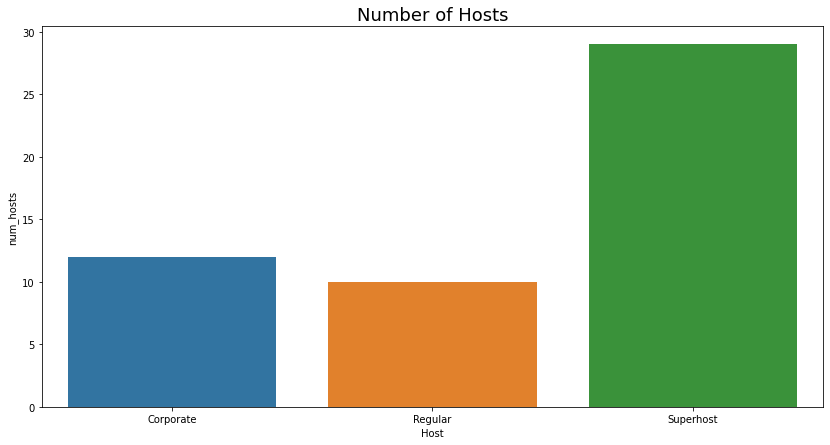

<IPython.core.display.Javascript object>

In [56]:
g = sns.barplot(
    data=comps.groupby(["Host"]).agg(num_hosts=("Stars", len)).reset_index(),
    x="Host",
    y="num_hosts",
)
_ = g.set_title("Number of Hosts", fontsize=18)

In [57]:
quants = np.quantile(comps.Stars[comps.Review > 10], q=[0.2, 0.4, 0.6, 0.8])

<IPython.core.display.Javascript object>

In [58]:
quants

array([4.798, 4.888, 4.95 , 4.986])

<IPython.core.display.Javascript object>

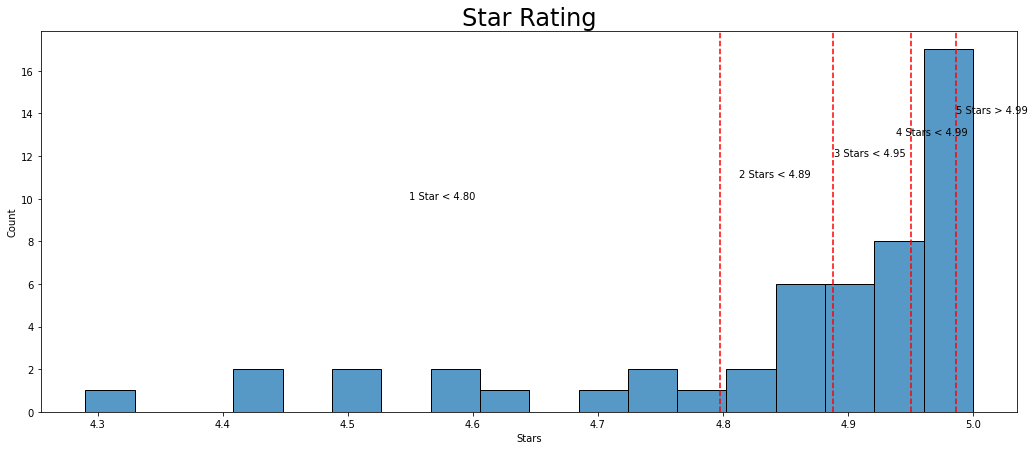

<IPython.core.display.Javascript object>

In [59]:
plt.rcParams["figure.figsize"] = (17.5, 7)
star_histogram = sns.histplot(comps.Stars, bins=18)
ax = plt.gca()
for quant in quants:
    ax.axvline(
        x=quant, ymin=0, ymax=16, color="red", linestyle="dashed"
    )  # Line on x = 2  # Bottom of the plot
# sns.vline(quants)
star_histogram.set_title("Star Rating", fontsize=24)
ax.text((quants[0] + 4.3) / 2, 10, s=f"1 Star < {quants[0]:.2f}")
ax.text((quants[1] + quants[0]) / 2 - 0.03, 11, s=f"2 Stars < {quants[1]:.2f}")
ax.text((quants[2] + quants[1]) / 2 - 0.03, 12, s=f"3 Stars < {quants[2]:.2f}")
ax.text((quants[3] + quants[2]) / 2 - 0.03, 13, s=f"4 Stars < {quants[3]:.2f}")
_ = ax.text(quants[3], 14, s=f"5 Stars > {quants[3]:.2f}")

In [60]:
fig = px.scatter(
    comps,
    y="manual Occupancy",
    x="manual ADR",
    color="Host",
    hover_data=["Notes", "url"],
)
fig.show()

<IPython.core.display.Javascript object>

In [61]:
comps[(comps["manual ADR"] > 300) & (comps["manual Occupancy"] > 0.5)]

,url,beds,bath,rabbu Occupancy,rabbu ADR,manual Occupancy,manual ADR,Notes,Location,Stars,Review,Cleaning Fee,Host
3,https://www.airbnb.com/rooms/721062423659714038,2,2,0.73,387,0.580645,350.0,"Fancy, Cabin Style",North Bend,4.89,19,125.0,Superhost
21,https://www.airbnb.com/rooms/23021120,2,3,0.40,650,0.645161,360.0,"Superhost, relatively new",Suncadia,4.93,14,200.0,Superhost
23,https://www.airbnb.com/rooms/33964064,2,3,0.83,328,0.774194,315.0,Not Superhost,Suncadia,4.92,102,150.0,Regular
34,https://www.airbnb.com/rooms/39804129,2,3,0.67,333,0.741935,333.0,Corporation,Ronald,4.83,29,190.0,Corporate
48,https://www.airbnb.com/rooms/772511804409507635?,2,2,0.43,584,0.677419,560.0,Way too nice to count as a comp,Lake Cle Elum,5.00,23,250.0,Corporate


<IPython.core.display.Javascript object>

In [62]:
exclude_indx = [3, 21, 23, 34, 11, 5, 48]
comps.drop(index=exclude_indx, inplace=True)

<IPython.core.display.Javascript object>

In [63]:
mod_data = comps[["manual ADR", "manual Occupancy", "Host"]].copy()
mod_data = mod_data[mod_data["manual ADR"] <= 500]
mod_data = pd.get_dummies(data=mod_data, prefix="host", columns=["Host"])
mod_data.drop(columns=["host_Regular"], inplace=True)
mod_data.head()

,manual ADR,manual Occupancy,host_Corporate,host_Superhost
0,134.0,0.903226,0,1
1,245.0,0.645161,0,1
2,189.0,0.645161,0,1
4,281.0,0.451613,0,1
6,180.0,0.483871,0,1


<IPython.core.display.Javascript object>

In [64]:
X = mod_data[["manual ADR"]]  # , "host_Corporate", "host_Superhost"]]
X = sm.add_constant(X)
y = mod_data[["manual Occupancy"]]
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       manual Occupancy   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.71
Date:                Mon, 17 Jul 2023   Prob (F-statistic):            0.00142
Time:                        23:10:23   Log-Likelihood:                 11.280
No. Observations:                  43   AIC:                            -18.56
Df Residuals:                      41   BIC:                            -15.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8376      0.095      8.774      0.000       0.645       1.030
manual ADR    -0.0014      0.000     -3.422      0.001      -0.002      -0.001
==============================================================================
Omnibus:                        0.085   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.959   Jarque-Bera (JB):                0.292
Skew:                          -0.022   Prob(JB):                        0.864
Kurtosis:                       2.599   Cond. No.                         777.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [67]:
fig = px.scatter(
    comps,
    y="manual Occupancy",
    x="manual ADR",
    color="Host",
    hover_data=["Notes", "url"],
)
fig.add_shape(
    type="line",
    x0=0,
    y0=0.837607,
    x1=500,
    y1=0.837607 + 500 * -0.001381,
)
fig.show()

<IPython.core.display.Javascript object>

In [66]:
res.params

const         0.837607
manual ADR   -0.001381
dtype: float64

<IPython.core.display.Javascript object>

In [68]:
p_opt = -0.837607 / (2 * -0.001381)
print(p_opt)
occ_opt = 0.837607 - 0.001381 * p_opt
print(occ_opt)

303.26104272266474
0.41880349999999994


<IPython.core.display.Javascript object>

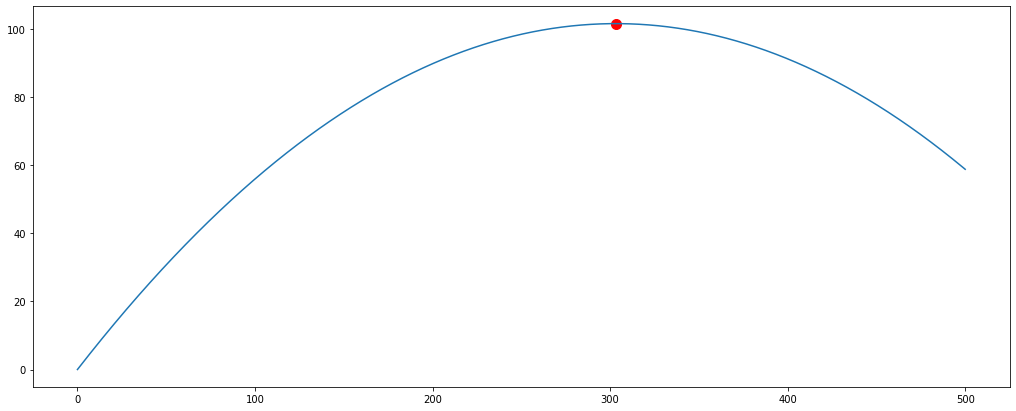

<IPython.core.display.Javascript object>

In [69]:
price_grid = np.linspace(0, 500, 10000)
X_grid = pd.DataFrame({"const": 1.0, "manual ADR": price_grid})
occ_grid = res.predict(X_grid)
rev_grid = price_grid * occ_grid
plt.plot(price_grid, 0.8 * rev_grid)
plt.scatter(p_opt, 0.8 * p_opt * occ_opt, color="red", s=100)

In [70]:
0.8 * p_opt * occ_opt

101.6054288847212

<IPython.core.display.Javascript object>

## Logistic Regression

<AxesSubplot: xlabel='manual ADR', ylabel='inv_logit_occ'>

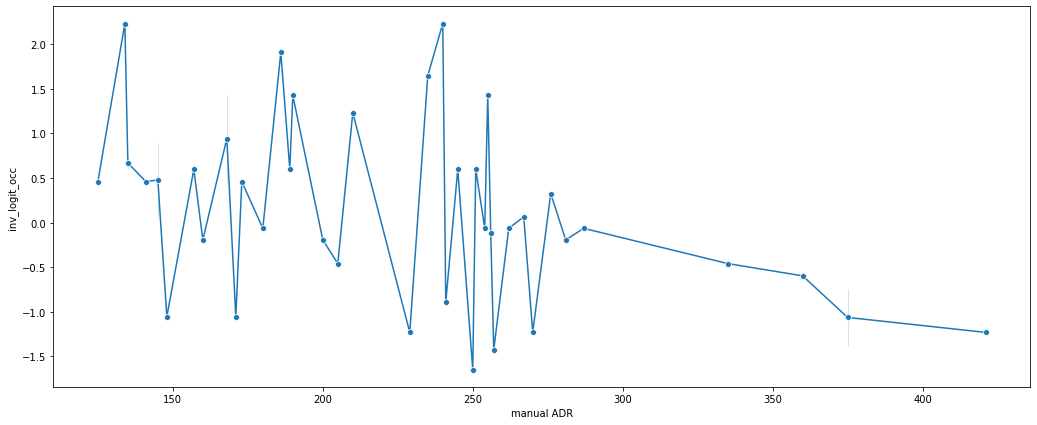

<IPython.core.display.Javascript object>

In [74]:
mod_data["inv_logit_occ"] = np.log(
    mod_data["manual Occupancy"] / (1 - mod_data["manual Occupancy"])
)
sns.lineplot(data=mod_data, x="manual ADR", y="inv_logit_occ", marker="o")

In [75]:
nights_occupied = (mod_data["manual Occupancy"] * 31).astype(int)
nights_vacant = 31 - nights_occupied
y_glm = np.c_[nights_occupied, nights_vacant]
y_glm[0:10]

array([[28,  3],
       [20, 11],
       [20, 11],
       [13, 18],
       [15, 16],
       [ 9, 22],
       [25,  6],
       [ 7, 24],
       [16, 15],
       [22,  9]])

<IPython.core.display.Javascript object>

In [76]:
glm_mod_matrix = sm.add_constant(X["manual ADR"])
glm_mod = sm.GLM(y_glm, glm_mod_matrix, family=sm.families.Binomial())
glm_res = glm_mod.fit()

<IPython.core.display.Javascript object>

In [77]:
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                   43
Model:                            GLM   Df Residuals:                       41
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -191.92
Date:                Mon, 17 Jul 2023   Deviance:                       226.91
Time:                        23:12:41   Pearson chi2:                     212.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7553
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4337      0.190      7.533      0.000       1.061       1.807
manual ADR    -0.0061      0.001     -7.526      0.000      -0.008      -0.005
==============================================================================
"""

<IPython.core.display.Javascript object>

In [79]:
glm_int = glm_res.params.loc["const"]
glm_slope = glm_res.params.loc["manual ADR"]
glm_res.params

const         1.433701
manual ADR   -0.006114
dtype: float64

<IPython.core.display.Javascript object>

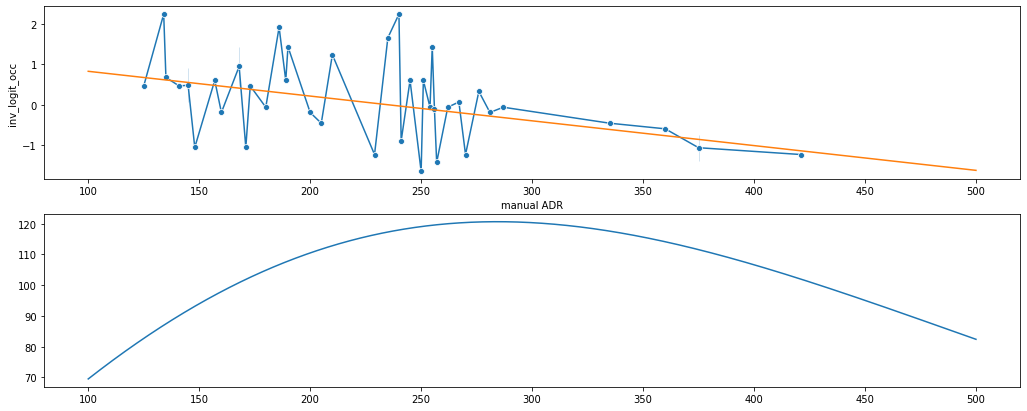

<IPython.core.display.Javascript object>

In [86]:
price_grid = np.linspace(100, 500, 4000)
logit_grid = glm_int + glm_slope * price_grid
demand_grid = 1 / (1 + np.exp(-(logit_grid)))
rev_grid = price_grid * demand_grid

fig, (ax1, ax2) = plt.subplots(2, 1)
logit_df = pd.DataFrame(
    {
        "price": np.linspace(100, 500, 4000),
        "logit_demand": np.array(
            [glm_int + glm_slope * x for x in np.linspace(100, 500, 4000)]
        ),
    }
)
sns.lineplot(data=mod_data, x="manual ADR", y="inv_logit_occ", marker="o", ax=ax1)
sns.lineplot(data=logit_df, x="price", y="logit_demand", ax=ax1)

ax2.plot(price_grid, rev_grid)

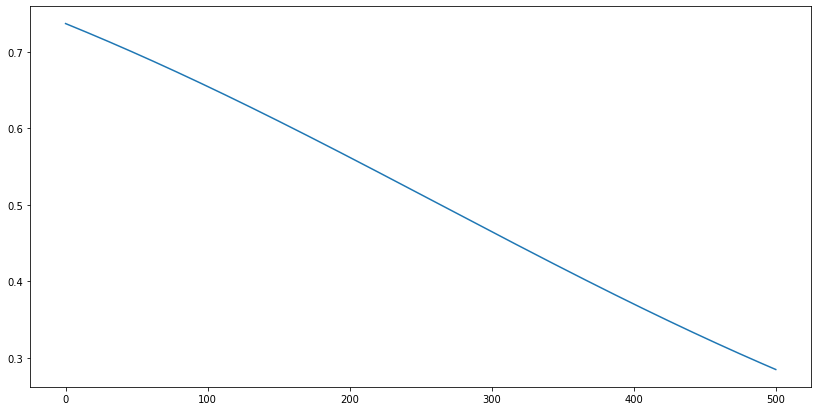

<IPython.core.display.Javascript object>

In [45]:
price_grid
demand_grid_hat = 1 / (1 + np.exp(-1 * (1.03 - 0.0039 * price_grid)))
rev_grid_hat = price_grid * demand_grid_hat
index_star = np.argmax(rev_grid_hat)
price_star = price_grid[index_star]
rev_star = rev_grid[index_star]
plt.plot(price_grid, demand_grid_hat)
# occupancy_pred = 1 / (1 + np.exp(-(1.00300 - 0.0039 * np.linspace(0, 501, 500))))

In [51]:
price_star

404.64046404640465

<IPython.core.display.Javascript object>

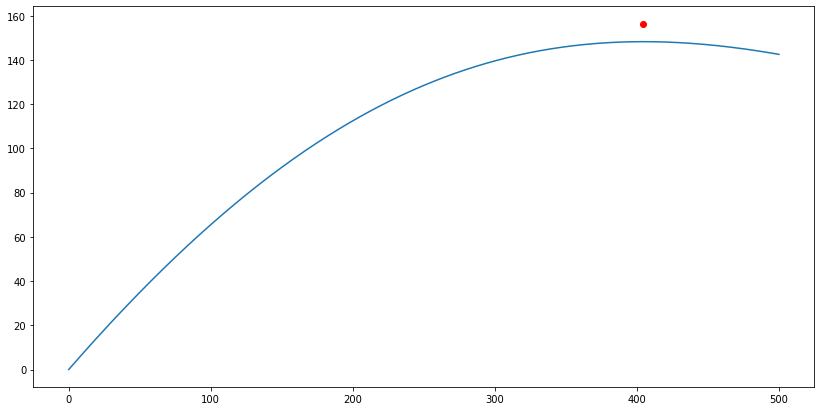

<IPython.core.display.Javascript object>

In [52]:
plt.plot(price_grid, price_grid * demand_grid_hat)
plt.scatter(price_star, rev_star, color="red")

In [70]:
data.exog = sm.add_constant(data.exog)

<IPython.core.display.Javascript object>

In [72]:
data.endog

0     60.3
1     52.3
2     53.4
3     57.0
4     68.7
5     48.8
6     65.5
7     70.5
8     59.1
9     62.7
10    51.6
11    62.0
12    68.4
13    69.2
14    64.7
15    75.0
16    62.1
17    67.2
18    67.7
19    52.7
20    65.7
21    72.2
22    47.4
23    51.3
24    63.6
25    50.7
26    51.6
27    56.2
28    67.6
29    58.9
30    74.7
31    67.3
Name: YES, dtype: float64

<IPython.core.display.Javascript object>

--------------------
## Seasonality

In [61]:
seasonality["seasonal_adj"] = seasonality["Revenue"] / 4866
seasonality["seasonal_revenue"] = (
    p_opt * occ_opt * seasonality["seasonal_adj"] * 365.25 / 12
)

<IPython.core.display.Javascript object>

In [62]:
seasonality

,Month,Revenue,seasonal_adj,seasonal_revenue
0,1,2311,0.474928,2261.879019
1,2,2388,0.490752,2337.242361
2,3,2312,0.475134,2262.857763
3,4,2080,0.427456,2035.788991
4,5,2833,0.582203,2772.783756
5,6,3901,0.801685,3818.083103
6,7,4866,1.000000,4762.571746
7,8,5370,1.103576,5255.859079
8,9,3403,0.699342,3330.668239
9,10,2452,0.503905,2399.882023


<IPython.core.display.Javascript object>

(0.0, 6000.0)

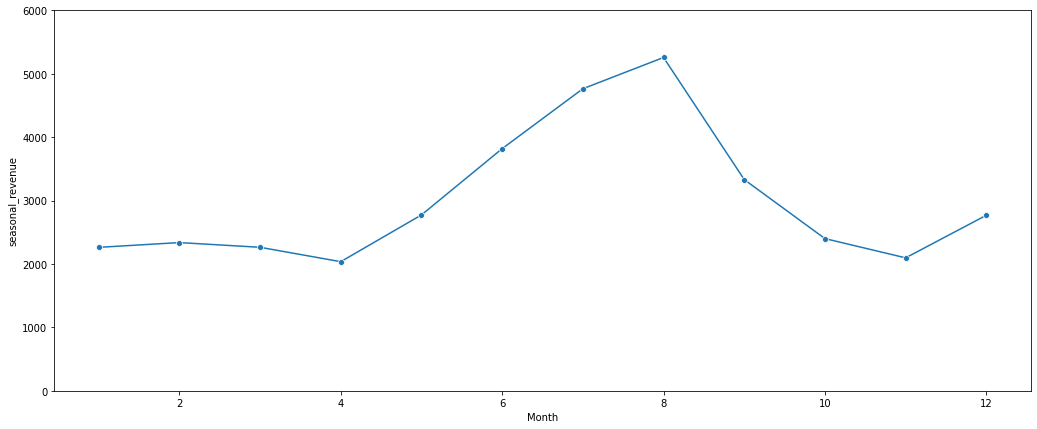

<IPython.core.display.Javascript object>

In [65]:
g = sns.lineplot(data=seasonality, x="Month", y="seasonal_revenue", marker="o")
g.set_ylim(0, 6000)

In [127]:
annual_rev = seasonality.seasonal_revenue.sum().round()
annual_rev

36102.0

<IPython.core.display.Javascript object>